
Étape 1. Analyse exploratoire des données.

Le dataset sur les tumeurs cérébrales contient 2 dossiers "non" et "oui" avec 98 et 155 images chacun. En utilisant le module imutils, nous allons extraire les chemins pour toutes les images et les stockerons dans une liste appelée image_paths.


In [ ]:
#solution import opencv

import os
opencv_dll_path = r"C:\Users\royal\opencv\build\x64\vc16\bin"
os.add_dll_directory(opencv_dll_path)
import cv2
print(cv2.getBuildInformation())


General configuration for OpenCV 4.11.0 =====================================
  Version control:               4.11.0

  Platform:
    Timestamp:                   2025-01-09T06:49:58Z
    Host:                        Windows 10.0.19045 AMD64
    CMake:                       3.23.3
    CMake generator:             Visual Studio 16 2019
    CMake build tool:            C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/MSBuild/Current/Bin/MSBuild.exe
    MSVC:                        1929
    Configuration:               Debug Release
    Algorithm Hint:              ALGO_HINT_ACCURATE

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      AVX (8 files):             + SSSE3 SSE4_1 POPCNT SSE4_2 AVX
      FP16 (0 files):            + SSSE3 SSE

In [1]:
from imutils import paths
import matplotlib.pyplot as plt 
import argparse
import os 
import cv2

#chargons les répertoires d'images 
path = "brain_tumor_dataset"


ImportError: DLL load failed while importing cv2: Le module spécifié est introuvable.

In [18]:
print(os.listdir(path))

['no', 'yes']


In [17]:
image_paths = list(paths.list_images(path))
print(len(image_paths))

253



Maintenant, nous allons itérer sur chacun des chemins et extraire le nom du répertoire (non ou oui dans notre cas, qui sert d'étiquette), et redimensionnons l'image à 224×224 pixels.

La fonction imread() du module cv2 convertit les images de tumeurs cérébrales en informations de type pixel.


In [19]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

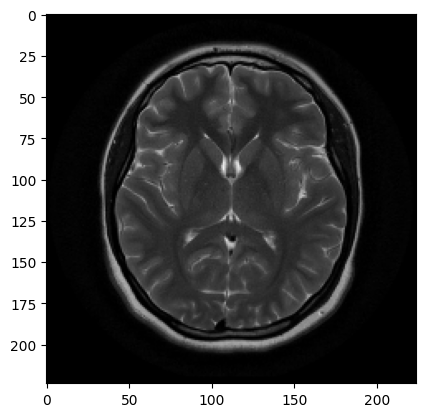

In [24]:
#traçons une image
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

Comme on peut le voir, nous avons stocké l'image et son étiquette respective dans des listes. Mais les étiquettes sont des chaînes de caractères qui ne peuvent pas être interprétées par des machines.

Il faut donc appliquer l'encodage One-hot aux étiquettes et normaliser les images et aussi convertir nos listes en tableaux numpy pour diviser davantage notre jeu de données

In [25]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np



In [26]:
images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

Avant de poursuivre, divisons notre dataset en train set et test set dans un rapport de 9-1 à l'aide de la fonction train_test_split() du package Scikit-learn.

In [27]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)


Étape 2 : Construction d'un modèle CNN

Avant de construire l'architecture de notre classificateur, nous devons comprendre ce qu'est un CNN.

Un réseau neuronal convolutif, ou Convolutional Neural Network (CNN en abrégé), est un réseau neuronal profond largement utilisé pour l'analyse des images visuelles. Ces types de réseaux fonctionnent bien pour des tâches comme la classification et la détection d'images, la segmentation d'images. Un CNN se compose de deux parties principales :

    Une couche convolutive qui fait le travail d'extraction des caractéristiques.
    Une couche entièrement connectée à la fin qui utilise la sortie des couches convolutionnelles et prédit la classe de l'image.

TensorFlow fournit ImageDataGenerator qui est utilisé pour l'augmentation des données (Data Augmentation). L'augmentation des données est extrêmement utile dans les cas où les données d'entrée sont très limitées. Nous utilisons donc différentes transformations pour augmenter la taille de l'ensemble de données. Il fournit diverses transformations comme la rotation, le retournement des images horizontalement, verticalement, le zoom, etc...

Nous utiliserons les transformations fill_mode et rotation_range pour remplir les pixels hors limites avec le pixel "le plus proche" d'eux et inclure une rotation de 15 degrés aux images.


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [29]:
train_generator = ImageDataGenerator(fill_mode='nearest', rotation_range= 15)



Comme la taille du dataset est très petite pour entraîner de tels réseaux neuronaux profonds, nous utiliserons la puissance du Transfer Learning pour faire les meilleures prédictions.

Le Transfer Learning consiste à exploiter les représentations des caractéristiques d'un modèle pré-entraîné, afin de ne pas avoir à former un nouveau modèle à partir de zéro. Pour ce projet, nous utiliserons le modèle de réseau de pointe VGG16. Il existe un certain nombre de modèles pré-entraînés pouvant être utilisés dans Keras.(Voir l'architecture du modèle VGG16 sur internet).


In [37]:
# Nous supprimerons la dernière couche du réseau VGG16
#  et ajoutons des couches adaptées à notre problème.

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D 
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16


In [39]:
base_model = VGG16(weights='imagenet', input_tensor=Input(shape=(224, 224, 3)), include_top= False)
base_input = base_model.input

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [42]:
base_output = base_model.output
base_output = AveragePooling2D(pool_size = (4, 4))(base_output)
base_output = Flatten(name='flatten')(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation = "softmax")(base_output)

En gélant les couches de notre modèle, le réseau n'est pas formé dès le début. Il utilisera les poids des couches précédentes et poursuivra la formation pour les couches que nous avons ajoutées par-dessus ces couches. Cela réduit considérablement le temps de formation.

In [43]:
#freezing train
for layer in base_model.layers:
    layer.trainable = False

Maintenant, construisons le modèle et compilons-le en utilisant Adam comme optimiseur avec un taux d'apprentissage de 0,001 et la précision comme métrique. Comme nous construisons un classificateur binaire et que l'entrée est une image, l'entropie croisée binaire est utilisée comme fonction de perte.

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 


In [45]:
#creation model & compilation
model = Model(inputs = base_input, outputs = base_output )
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')


In [46]:
#architecture de notre modele
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 1, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Étape 3 : Entraînement et évaluation du modèle

Avant de commencer l'entraînement de notre modèle, enregistrons les hyperparamètres suivants. Le modèle sera entraîné sur 10 époques (itérations complètes) avec train_steps pour l'ensemble d'entraînement et validation_steps pour l'ensemble de validation dans chaque époque. La taille du lot pour chaque époque est de 8.


In [57]:
batch_size = 8
train_steps = len(X_train) // batch_size
validation_steps = len(X_test)  // batch_size
epochs = 10

In [58]:
history = model.fit(
    train_generator.flow(X_train, y_train, batch_size= batch_size),
    steps_per_epoch= train_steps, 
    validation_data = (X_test, y_test), 
    validation_steps= validation_steps,
    epochs= epochs)



Epoch 1/10


C:\Users\royal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 602ms/step - accuracy: 0.7211 - loss: 0.5412 - val_accuracy: 0.9615 - val_loss: 0.3581
Epoch 2/10
 1/28 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.8750 - loss: 0.4073

C:\Users\royal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8750 - loss: 0.4073 - val_accuracy: 0.9615 - val_loss: 0.3608
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 731ms/step - accuracy: 0.7879 - loss: 0.5202 - val_accuracy: 0.9615 - val_loss: 0.3260
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7500 - loss: 0.4623 - val_accuracy: 0.9615 - val_loss: 0.3304
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 611ms/step - accuracy: 0.8219 - loss: 0.4722 - val_accuracy: 0.9231 - val_loss: 0.2899
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.2465 - val_accuracy: 0.9231 - val_loss: 0.2907
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 657ms/step - accuracy: 0.8093 - loss: 0.4540 - val_accuracy: 0.9231 - val_loss: 0.3143
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8750 - loss: 0.6920 - val_accuracy: 0.9231 - val_loss: 0.3022
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step - accuracy: 0.7885 - loss: 0.4617 - val_accuracy: 0.9231 - val_

Notre modèle a obtenu une précision de 96,15 % sur l'ensemble de test.

In [59]:
#Évaluons maintenant notre modèle à l'aide de la fonction predict().

from sklearn.metrics import classification_report, confusion_matrix



In [60]:
predictions = model.predict(X_test, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(y_test, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))


cm = confusion_matrix(actuals, predictions)
print(cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step
              precision    recall  f1-score   support

          no       0.83      1.00      0.91        10
         yes       1.00      0.88      0.93        16

    accuracy                           0.92        26
   macro avg       0.92      0.94      0.92        26
weighted avg       0.94      0.92      0.92        26

[[10  0]
 [ 2 14]]


Les prédictions faites par le modèle seront un tableau dont chaque valeur représente la probabilité que l'image appartienne à cette catégorie. Nous prenons donc le maximum de toutes ces probabilités et attribuons l'étiquette prédite à cette entrée d'image.

Une matrice de confusion est une représentation matricielle montrant comment le modèle entraîné prédit chaque classe cible par rapport aux comptes. Elle contient 4 valeurs dans le format suivant :

TP FN
FP TN

    Vrai positif (TP) : La cible est positive et le modèle l'a prédite comme positive.
    Faux négatif (FN) : La cible est positive et le modèle l'a prédite comme négative.
    Faux positif (FP) : La cible est négative et le modèle l'a prédite comme positive.
    Vrai négatif (TN) : La cible est négative et le modèle l'a prédite comme négative.

Le rapport de classification fournit un résumé des mesures de précision, de rappel et de score F1 pour chaque classe/étiquette de l'ensemble de données. Il fournit également la précision et le nombre d'échantillons de données de chaque étiquette catégorisée.

Précision globale du modèle.

Trouvons maintenant la précision globale du modèle en utilisant la formule : (TP + TN) / (TP + FN + FN + TN)

total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("La précision globale de notre modèle est de: {:.4f}".format(accuracy))

La précision globale de notre modèle est de: 0.92



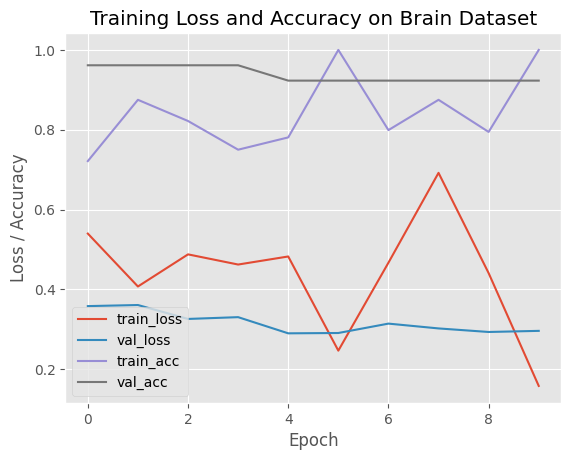

In [61]:
# Tracons les métriques en utilisant matplotlib

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("Training Loss and Accuracy on Brain Dataset.jpg")



Dans le cadre de la classification des tumeurs cérébrales par apprentissage automatique, nous avons construit un classificateur binaire pour détecter les tumeurs cérébrales à partir d'images IRM. Nous avons construit notre classificateur en utilisant transfer learning et avons obtenu une précision de 96,15 % et visualisé la performance globale de notre modèle.